In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.autograd import Variable

running variables:

In [80]:
#Choosing whether to train the model or use the existing weights
training = False

#Choosing the type of model
ORS = True

#if ORS is true, Choosing if OOD
OOD = True

In [81]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

create dataset

In [82]:

# Usaged example
# Load the MNIST and OOD datasets
# Define the transformations
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

torch.manual_seed(0)
np.random.seed(0)

train_loader = DataLoader(train_subset , batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)


cifar_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) ])

mnist = MNIST(root='./data', train=False, download=True, transform=mnist_transform)
ood = CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

# sample ~500-1000 samples from CIFAR
# ... #
# Combine the datasets
combined_ds = CombinedDataset(mnist, ood)
# large batchsize for inference is recommended
batch_size = 1024

# torch.manual_seed(0)
# np.random.seed(0)




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


for change the data to test:

In [83]:
data_loader = DataLoader(combined_ds, batch_size=batch_size, shuffle=False)

evaluation accuracy function

In [84]:
def eval_model(model, data_loader, device, OOD = False):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0
    all_labels = []
    all_data = []
    all_outputs = torch.tensor([])
    if torch.cuda.is_available():
        all_outputs = all_outputs.cuda()

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            all_data.extend(data.cpu().numpy())
            data = data.view(data.size(0), -1).to(device)
            labels = labels.to(device)
            all_labels.extend(labels.cpu().numpy())
            if ORS:
              if OOD:
                predicted = model.forwardOOD(data)
              else:
                predicted = model.forwardclass(data)

            else:
              outputs = model(data)
              _, predicted = torch.max(outputs.data, 1)

            all_outputs = torch.cat((all_outputs, predicted))


            # print(f"predicted {predicted[:10]}")
            # print(f"labels {labels[:10]}")

            ### Modify output if needed ###

            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            # probas, y_pred = torch.max(outputs, 1)


	    # Assuming the model retuns the predicted label (N_batch, )
	    # y_pred = outputs

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            if OOD:
              for i in range(len(labels)):
                if labels[i] == 10:
                  labels[i] = 1
                else:
                  labels[i] = 0
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            # pred_mnist = y_pred[mask_mnist]
            # pred_ood = y_pred[mask_ood]

            pred_mnist = predicted[mask_mnist]
            pred_ood = predicted[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)
    all_outputs = all_outputs.type(torch.int)

    return acc_mnist, acc_ood, acc_total, all_outputs, all_labels


In [85]:
def normalize(data):
  min_val = np.min(data)
  max_val = np.max(data)
  normalized_data = (data - min_val) / (max_val - min_val)
  return normalized_data

train model, using Kmeans to classify the data

In [86]:
def extract_embeddings(data_loader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.view(data.size(0), -1)  # Flatten the images
            embedding = model.embedding(data)
            # embedding = model.encoder(data)
            embeddings.append(embedding)
            labels.append(target)
    return torch.cat(embeddings), torch.cat(labels)

In [87]:
def Kmeans_train(model, embeddings):
  train_embeddings_np = embeddings.cpu().numpy()
  kmeans = KMeans(n_clusters=10, random_state=0, max_iter= 500).fit(train_embeddings_np)
  model.kmeans = kmeans


  # Convert cluster centers to a PyTorch tensor
  cluster_centers_tensor = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

  # Save the tensor
  torch.save(cluster_centers_tensor, 'cluster_centers.pt')
  return kmeans, embeddings


def train_model(model, num_epochs, train_loader, optimizer, criterion, lr = 0.001, OSR =False):
  # Train the model
  loss_list = []
  device = model.device
  for epoch in range(num_epochs):
      running_loss = 0.0
      for images, label in train_loader:
          images = images.view(images.size(0), -1)
          label = label.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, label)
          loss.backward()
          optimizer.step()
      loss_list.append(loss.item())
      print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
      if epoch == num_epochs - 1:
        model_weights = model.state_dict()
        torch.save(model_weights, "model_weights.pth")
        torch.save(model, "model.pth")

  if OSR:
     embeddings, labels = extract_embeddings(train_loader, model)
     kmeans, embeddings = Kmeans_train(model, embeddings)
  return loss_list, kmeans, embeddings

A function for classifying points based on their proximity to the center points we created in the k-means model

In [88]:
def classify_new_data(images, kmeans, threshold):
  images = images.cpu().numpy()

  distances = kmeans.transform(images)
  distances = normalize(distances)
  # print(f"distances = {distances}")
  nearest_clusters = distances.argmin(axis=1)
  is_outlier = distances[np.arange(len(nearest_clusters)), nearest_clusters] > threshold
  classs = nearest_clusters
  classs[is_outlier] = 10
  # print(f"classs = {classs}")
  return classs

function for printing the loss graph

In [89]:
def print_loss(loss_train, title):
  plt.plot(loss_train, label="training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend()
  plt.grid()
  plt.title(title)

Mnist model

In [90]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.embedding  = nn.Sequential( nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10))
    self.sofMax = nn.Sequential(nn.LogSoftmax(dim=1))
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  def forward(self, x):
    x = self.embedding (x.to(self.device))
    x = self.sofMax(x)
    return x

The ORS model

In [91]:
class ORS_model(Model):
  def __init__(self, threshold):
    super(ORS_model, self).__init__()
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.kmeans = None
    self.threshold = threshold

  def forwardclass(self, x):
    x = self.embedding(x.to(self.device))
    # x = self.encoder(x.to(self.device))
    probas, y_pred = torch.max(x, 1)
    x = x.view(x.size(0), -1)
    classs = classify_new_data(x.detach(), self.kmeans, self.threshold)
    # print(f"classs = {classs}")
    for i in range(len(classs)):
      if classs[i] == 10:
        y_pred[i] = 10
    # print(f"y_pred = {y_pred}")
    return y_pred

  def forwardOOD(self, x):
    y_pred = self.forwardclass(x)
    for i in range(len(y_pred)):
      if y_pred[i] == 10:
        y_pred[i] = 1
      else:
        y_pred[i] = 0
    return y_pred


In [92]:
model = None
if ORS:
  model = ORS_model(0.25)
else:
  model = Model()
model.to(model.device)

if training:
  # Hyperparameters
  learning_rate = 0.0001
  num_epochs = 80


  optimizer = optim.Adam(model.parameters())
  criterion = nn.NLLLoss()
  loss_list, kmeans, embeddings = train_model(model, num_epochs, train_loader, optimizer, criterion, learning_rate, ORS)
  print(model.kmeans)

else:
  model.load_state_dict(torch.load("model_weights.pth",  map_location=torch.device(model.device)))
  # Load the tensor
  loaded_centers = torch.load('cluster_centers.pt')
  model.kmeans = KMeans(n_clusters=10, random_state=0)
  model.kmeans.cluster_centers_ = loaded_centers.numpy()
  model.eval()


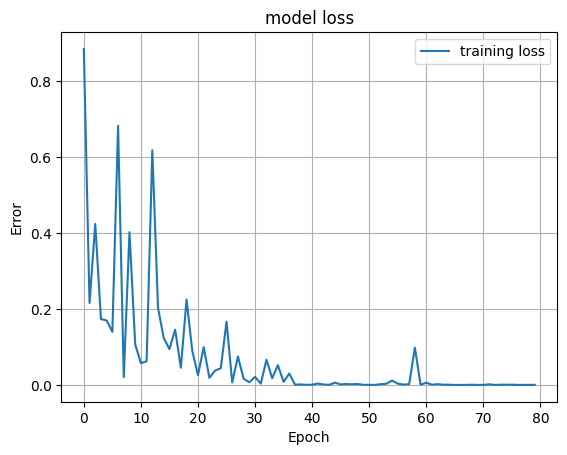

In [93]:
print_loss(loss_list, "model loss" )


Calculating accuracy and confusion matrix for the ORS problem

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

acc_mnist, acc_ood, acc_total, y_pred, y_true = eval_model(model, data_loader, device)
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

MNIST Accuracy: 92.99%
OOD Accuracy: 57.64%
Total Accuracy: 75.31%


In [95]:
confusion_matrix(y_true, y_pred.cpu().numpy())

array([[ 925,    1,    0,    0,    0,    4,    2,    1,    0,    0,   47],
       [   0, 1123,    0,    2,    0,    0,    5,    1,    1,    0,    3],
       [   5,    1,  922,    9,    2,    1,    4,    6,    4,    0,   78],
       [   0,    3,   15,  928,    0,   14,    0,   10,    8,    1,   31],
       [   5,    0,    8,    0,  927,    3,    2,    2,    1,   19,   15],
       [   3,    1,    1,   13,    1,  782,    8,    2,   14,    6,   61],
       [   6,    3,    4,    0,    3,    3,  902,    1,    2,    0,   34],
       [   1,   12,   11,    5,    3,    0,    0,  937,    1,   15,   43],
       [   3,    1,    6,   15,    5,    7,    5,    2,  903,    6,   21],
       [   4,    3,    0,    7,   16,    6,    1,    6,    5,  950,   11],
       [ 152,  262,  613,  230,  475,  303,  640,  919,  314,  328, 5764]])

Calculating accuracy and confusion matrix for the OOD problem

In [96]:
acc_mnist, acc_ood, acc_total, y_pred_OOD, y_true_OOD = eval_model(model, data_loader, device, OOD)
print("OOD accuracy")
print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')

OOD accuracy
MNIST Accuracy: 96.56%
OOD Accuracy: 57.64%
Total Accuracy: 77.10%


classs 0-9

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


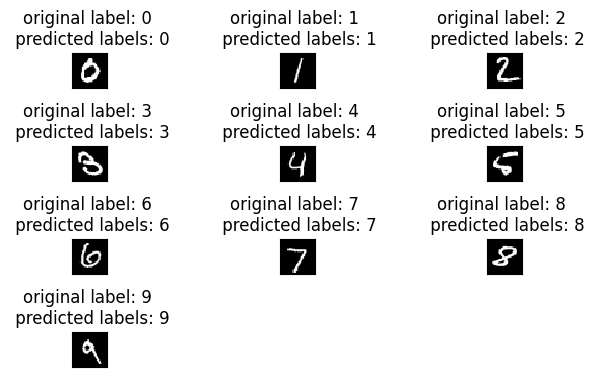

In [97]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
input = images.unsqueeze(1).to(device)
input = images.view(-1, 784).to(device)
outputs = torch.exp(model(input))

images_to_plot = []

for i in range(10):
  for j in range(len(labels)):
    if labels[j] == i and outputs[j].argmax().item() == i:
      images_to_plot.append(j)
      break

fig = plt.figure()
for i in range(10):
  plt.subplot(5,3,i+1)
  plt.tight_layout()
  plt.imshow(images[images_to_plot[i]][0], cmap='gray', interpolation='none')
  plt.title(f"original label: {labels[images_to_plot[i]]} \n predicted labels: {outputs[images_to_plot[i]].argmax().item()}")
  plt.xticks([])
  plt.yticks([])
plt.show()

class 0-10

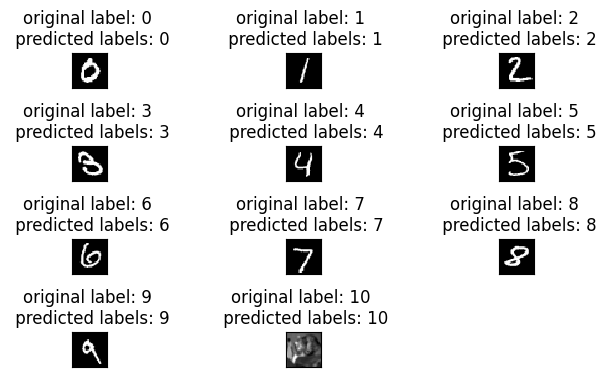

In [98]:
if ORS:
  all_labels = []
  all_data = []
  all_outputs = torch.tensor([])
  if torch.cuda.is_available():
      all_outputs = all_outputs.cuda()
  for data, labels in data_loader:
        all_data.extend(data.cpu().numpy())
        data = data.view(data.size(0), -1).to(device)
        all_labels.extend(labels.cpu().numpy())
        # labels = labels.to(device)
        data = data.unsqueeze(1).to(device)
        data = data.view(-1, 784).to(device)
        outputs = model.forwardclass(data)
        all_outputs = torch.cat((all_outputs, outputs))


  all_outputs = all_outputs.type(torch.int)

  images_to_plot2 = []

  for i in range(11):
    for j in range(len(all_labels)):
      if all_labels[j] == i and all_outputs[j] == i:
        images_to_plot2.append(j)
        break

  fig = plt.figure()
  for i in range(11):
    plt.subplot(5,3,i+1)
    plt.tight_layout()
    plt.imshow(all_data[images_to_plot2[i]][0], cmap='gray', interpolation='none')
    plt.title(f"original label: {all_labels[images_to_plot2[i]]} \n predicted labels: {all_outputs[images_to_plot2[i]]}")
    plt.xticks([])
    plt.yticks([])
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


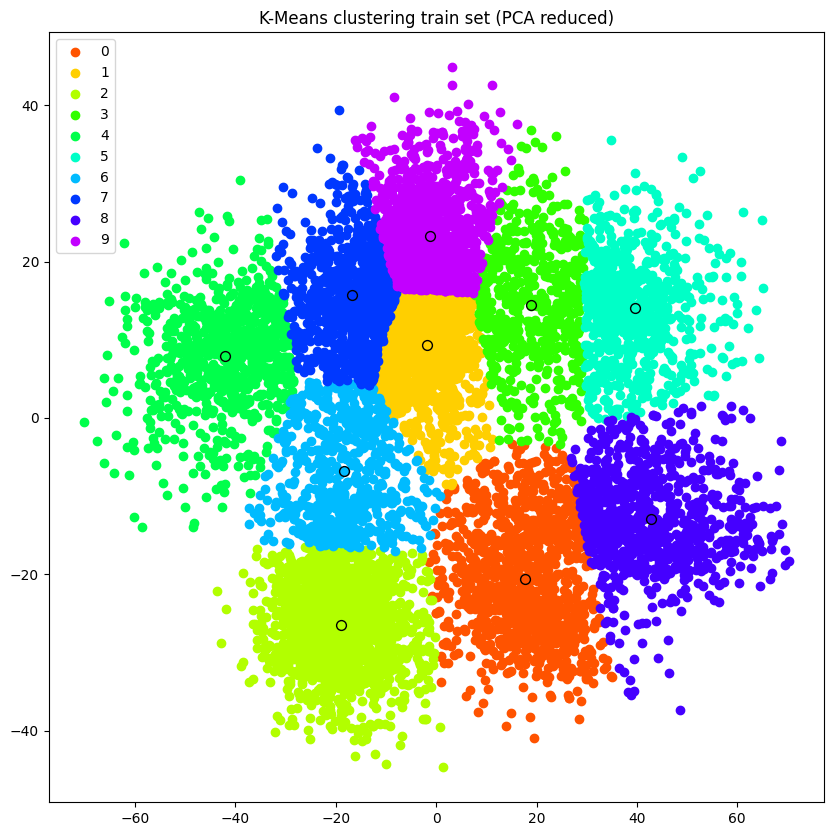

In [99]:
# Reduce dimensionality with PCA
pca = PCA(n_components=2)
embeddings_reduced = pca.fit_transform(embeddings)

# Subsample data (optional)
# sample_size = 1000
# indices = np.random.choice(len(embeddings_reduced), sample_size, replace=False)
# embeddings_reduced = embeddings_reduced[indices]
# labels = np.array(labels)[indices]

# K-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings_reduced)

# Visualization
clrs = sns.color_palette('gist_rainbow', n_colors=10)
plt.figure(figsize=(10, 10))
y_kmean = kmeans.labels_
classes_kmeans = np.unique(kmeans.labels_)
for k in classes_kmeans:
    Xk = embeddings_reduced[y_kmean == k]
    yk = y_kmean[y_kmean == k]
    color = clrs[k]
    plt.scatter(Xk[:, 0], Xk[:, 1], color=color, label=k)
    # plot the cluster center
    Xk_mean = kmeans.cluster_centers_[k]
    plt.scatter(Xk_mean[0], Xk_mean[1], color=color, s=50, edgecolors='black')

plt.legend()
plt.title("K-Means clustering train set (PCA reduced)")
plt.show()
